# Importing Python libraries

In [1]:
#Python libraries for web scraping
from bs4 import BeautifulSoup
import requests

#Python libraries for NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

#Python libraries for NLP tasks
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Python libraries for reading pdf, doc
import re
import io
import docx2txt
from pdfminer.converter import TextConverter
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfpage import PDFPage

#Python libraries for wordclouds
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Loading and pre-processing resume 

In [2]:
#Converting pdf file to text
def PDF2Text(pdf_doc):
    rsmgr = PDFResourceManager()
    handler = io.StringIO()
    converter = TextConverter(rsmgr,handler)
    interpreter = PDFPageInterpreter(rsmgr,converter)
    
    with open(pdf_doc,'rb') as fh:
         for page in PDFPage.get_pages(fh,caching=True,check_extractable=True):
                interpreter.process_page(page)
        
    text = handler.getvalue()
    converter.close()
    handler.close()
    
    if text: 
        return text

In [3]:
#Converting MS document to text
def Doc2Text(doc_cv):
    text = docx2txt.process(doc_cv)
    text = text.replace('\n',' ')
    if text:
        return text

In [4]:
def TextPreprocess(text):

    #removing emails
    text = re.sub('[\w\.-]+@[\w\.-]+','',text)
    #removing http links
    text = re.sub('(www|http:|https:)+[^\s]+[\w]','',text)
    #removing web directory, sub-directory url
    text = re.sub('[\w]+[0-9]?\.[\w]+[0-9]?/([\w]+[0-9]?/?)*','',text) 
    #removing numbers, or telephone
    text = re.sub('[\+]?[0-9]+','',text)
    #replacing slash / with space
    text = re.sub('/', ' ',text)
    #removing single quote with characters e.g. 's, 're, 'll
    text = re.sub("'[\w]+",'', text)
    #lowercasing all the words
    text = text.lower()
    #tokenizing into words
    tokens = word_tokenize(text)
    #removal of stopwords, rare words
    lstopwords = []
    with open('stopwords.csv','r') as file:
        lines=file.readlines()
        for line in lines:
            lstopwords.append(line.strip())
    
    lstopwords.extend(stopwords.words('english'))
    text = ' '.join(token for token in tokens if token not in lstopwords)
    
    #removing special characters
    SpecialC = ['+','*',',',':',';','•','%','?','!','|','$','&','#','etc.','e.g.','.','–','(',')','“','”','’','\uf0b7','\u200b']
    for c in SpecialC:
        text =str(text).replace(c,'')
   
    return text

In [5]:
def Vectorization(documents, dtype):
    
    vectorizer = None
    if dtype == 'count':
        vectorizer = CountVectorizer()
    elif dtype == 'tfidf':
        vectorizer = TfidfVectorizer()
   
    spare_matrix = vectorizer.fit_transform(documents)
    #convert to array
    doc_term_array = spare_matrix.toarray()
    #convert to dataframe (if any)
    df = pd.DataFrame(doc_term_array, columns=vectorizer.get_feature_names_out())    
    
    return df, doc_term_array

def Cosine_Similarity(v1, v2):  
    return np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2))

In [6]:
resume = PDF2Text('Phu_CV.pdf')
resume = TextPreprocess(resume)
resume

'phu phan sydney  nsw  australia    objective analytical  organized  detail-oriented business data analyst complex businesses  multi-segments  corporate environments  target support achieving operational excellence improving business performance  supporting projects  initiatives enable cost reduction financial profitability  experience charles darwin  northern territory  australia research student   worked closely cdu lecturer research project analyze science foundation grants  using literature-based discovery techniques explore hidden insights predict topics future grants   developed comprehensive framework data extraction  text pre-processing  data mining model  validating  storytelling outcomes  northern territory government  australia vacation employee    provided administrative support regarding ntg jira issues  dashboards creation  report testing   investigated scoped solutions migrate data  documents ms sharepoint  ntg mylearning portal confluence system   developed vba macros a

# Resume Wordcloud

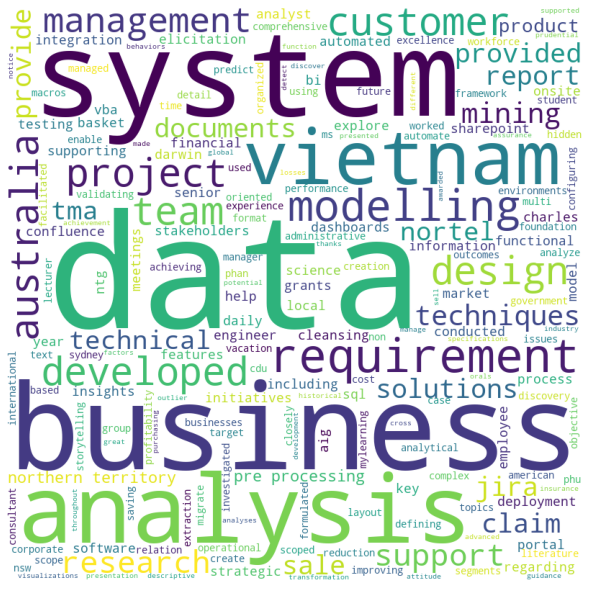

In [10]:
tokens = resume.split()
words = ''
words += ' '.join(tokens) + ' '
wordcloud = WordCloud(width=800, height=800,background_color='white',min_font_size=10).generate(words)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# Scraping job ads from seek.com.au

In [11]:
headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36"}
url = 'https://www.seek.com.au/{}-jobs{}?page={}&sortmode={}'
title = 'Data Analyst'
location = 'Sydney'
page = '1'
sort = 'KeywordRelevance' #or 'ListedDate'

title = title.strip().replace(' ','-')
location = '/in-' + location.strip().replace(' ','-') if location else ''
url = url.format(title, location, page, sort)
url

'https://www.seek.com.au/Data-Analyst-jobs/in-Sydney?page=1&sortmode=KeywordRelevance'

In [12]:
#scraping job ads from seeks
page = requests.get(url, headers=headers)

if page.status_code ==200:
    soup = BeautifulSoup(page.content,'html.parser')
    search = soup.find('div',{'data-automation':'searchResults'})
                        
    if not search is None:
        jobs = search.find_all('div',{'class':'_1wkzzau0 a1msqi7e'})
        list_job = []
        
        for job in jobs:
            title = job.find('a',{'data-automation':'jobTitle'}).text 
            link = 'https://www.seek.com.au'+job.find('a')['href'].split('?')[0]
            comobj = job.find('a',{'data-automation':'jobCompany'})
            company = comobj.text if comobj is not None else 'Private Advertiser'
            location = job.find('a',{'data-automation':'jobLocation'}).text
            subclassification = job.find('a',{'data-automation':'jobSubClassification'}).text
            classification = job.find('a',{'data-automation':'jobClassification'}).text.replace('(','').replace(')','')
            salobj = job.find('span',{'data-automation':'jobSalary'})
            salary = salobj.text if salobj is not None else 'N/A' 
            premjob = job.find('span',{'data-automation':'jobPremium'})
            dateobj = job.find('span',{'data-automation':'jobListingDate'})
            listdate = dateobj.text if dateobj is not None else premjob.text
            shortJD = job.find('span',{'data-automation':'jobShortDescription'}).text
                          
            #get the details of job description
            pagejd = requests.get(link, headers = headers)
            soupjd = BeautifulSoup(pagejd.content,'html.parser')
            div_text = soupjd.find('div',{'data-automation':'jobAdDetails'}).find_all(text=True)
            jd = ' '.join(text for text in div_text)
                        
            dict_job = {'Job title':title,'Company':company,'Listed date': listdate,
                        'Location':location,'Classification':classification,
                        'Sub classification':subclassification,'Salary Package':salary,
                        'Short JD':shortJD,'Job Description':jd,'Link':link
                                        }
            list_job.append(dict_job)
                                               
df = pd.DataFrame(list_job)  
df

,Job title,Company,Listed date,Location,Classification,Sub classification,Salary Package,Short JD,Job Description,Link
0,Commercial Performance Analyst - BINGE,Foxtel Group,Featured,Artarmon,Accounting,Analysis & Reporting,Base + Super + Foxtel Benefits,An exceptional opportunity to grow and diversi...,Join Our Team As a Commercial Performance Anal...,https://www.seek.com.au/job/69013279
1,Commercial Performance Analyst - BINGE,Foxtel Group,Featured,Artarmon,Consulting & Strategy,Analysts,Base + Super + Foxtel Benefits,An exceptional opportunity to grow and diversi...,Join Our Team As a Commercial Performance Anal...,https://www.seek.com.au/job/69013278
2,Data Analyst,ASIC,1d ago,Sydney NSW,Banking & Financial Services,Analysis & Reporting,N/A,Establish data and reporting models that provi...,\n Establish data and reporting models that pr...,https://www.seek.com.au/job/68989483
3,Data Analyst,SustainAbility Consulting,4d ago,Sydney NSW,Banking & Financial Services,Analysis & Reporting,"$125,000 + Super",Looking for a passionate Data Analyst to provi...,The Role: We are looking for a passionate Dat...,https://www.seek.com.au/job/68964543
4,Data Analyst,SSI,4h ago,Ashfield,Information & Communication Technology,Business/Systems Analysts,"$94,000 - $98,000 + Salary Packaging options","The position will provide weekly, monthly and ...",\n Full Time Fixed-term contract until 30 June...,https://www.seek.com.au/job/69016080
5,Data Analyst,ASIC,3d ago,Sydney NSW,Banking & Financial Services,Analysis & Reporting,N/A,Provide on demand data analysis and use statis...,\n Provide on demand data analysis and use sta...,https://www.seek.com.au/job/68971040
6,Data Analyst - JP7255,The Recruitment Company,5h ago,Sydney NSW,Information & Communication Technology,Business/Systems Analysts,$61 to $68 per hour plus super,6 month contract with possible extension\nParr...,\n Experienced Data Analyst required for an ...,https://www.seek.com.au/job/69013571
7,2023 Project Grace - Data & Business Analyst G...,FDM Group Australia Pty Ltd.,4d ago,Sydney NSW,Information & Communication Technology,Business/Systems Analysts,"$65,000 - $69,999 salary package",Project Grace is a Graduate Program for women ...,*One of the key requirements for this role is ...,https://www.seek.com.au/job/67841654
8,Junior Business Analyst,Beaumont People,8d ago,Sydney NSW,Information & Communication Technology,Business/Systems Analysts,N/A,"Are you a enthusiastic, dynamic, recent gradua...",Amazing opportunity to Kick-start Your Busines...,https://www.seek.com.au/job/68858760
9,Analyst - Master Data,CSR Limited,22h ago,North Ryde,Information & Communication Technology,Business/Systems Analysts,N/A,New role for a PIM Analyst to join an exciting...,\n CSR Limited is a leading Australian Manuf...,https://www.seek.com.au/job/69003601


# Calculating resume and job similarity 

In [13]:
#computing cosine similarity
job_descriptions = df[['Job Description']].values

list_cosine = []

for job_description in job_descriptions:
    _, vector = Vectorization([resume, TextPreprocess(str(job_description))], 'tfidf')
    similarity_score = round(Cosine_Similarity(vector[0], vector[1])*100,2)
    dict_cosine = {'Matching percent':'{}%'.format(similarity_score)}
    list_cosine.append(dict_cosine)

df_matching = pd.DataFrame(list_cosine)
df = pd.concat([df_matching, df], axis = 1)
df   

,Matching percent,Job title,Company,Listed date,Location,Classification,Sub classification,Salary Package,Short JD,Job Description,Link
0,14.65%,Commercial Performance Analyst - BINGE,Foxtel Group,Featured,Artarmon,Accounting,Analysis & Reporting,Base + Super + Foxtel Benefits,An exceptional opportunity to grow and diversi...,Join Our Team As a Commercial Performance Anal...,https://www.seek.com.au/job/69013279
1,14.65%,Commercial Performance Analyst - BINGE,Foxtel Group,Featured,Artarmon,Consulting & Strategy,Analysts,Base + Super + Foxtel Benefits,An exceptional opportunity to grow and diversi...,Join Our Team As a Commercial Performance Anal...,https://www.seek.com.au/job/69013278
2,18.57%,Data Analyst,ASIC,1d ago,Sydney NSW,Banking & Financial Services,Analysis & Reporting,N/A,Establish data and reporting models that provi...,\n Establish data and reporting models that pr...,https://www.seek.com.au/job/68989483
3,25.84%,Data Analyst,SustainAbility Consulting,4d ago,Sydney NSW,Banking & Financial Services,Analysis & Reporting,"$125,000 + Super",Looking for a passionate Data Analyst to provi...,The Role: We are looking for a passionate Dat...,https://www.seek.com.au/job/68964543
4,22.19%,Data Analyst,SSI,4h ago,Ashfield,Information & Communication Technology,Business/Systems Analysts,"$94,000 - $98,000 + Salary Packaging options","The position will provide weekly, monthly and ...",\n Full Time Fixed-term contract until 30 June...,https://www.seek.com.au/job/69016080
5,14.69%,Data Analyst,ASIC,3d ago,Sydney NSW,Banking & Financial Services,Analysis & Reporting,N/A,Provide on demand data analysis and use statis...,\n Provide on demand data analysis and use sta...,https://www.seek.com.au/job/68971040
6,14.05%,Data Analyst - JP7255,The Recruitment Company,5h ago,Sydney NSW,Information & Communication Technology,Business/Systems Analysts,$61 to $68 per hour plus super,6 month contract with possible extension\nParr...,\n Experienced Data Analyst required for an ...,https://www.seek.com.au/job/69013571
7,9.49%,2023 Project Grace - Data & Business Analyst G...,FDM Group Australia Pty Ltd.,4d ago,Sydney NSW,Information & Communication Technology,Business/Systems Analysts,"$65,000 - $69,999 salary package",Project Grace is a Graduate Program for women ...,*One of the key requirements for this role is ...,https://www.seek.com.au/job/67841654
8,10.5%,Junior Business Analyst,Beaumont People,8d ago,Sydney NSW,Information & Communication Technology,Business/Systems Analysts,N/A,"Are you a enthusiastic, dynamic, recent gradua...",Amazing opportunity to Kick-start Your Busines...,https://www.seek.com.au/job/68858760
9,10.45%,Analyst - Master Data,CSR Limited,22h ago,North Ryde,Information & Communication Technology,Business/Systems Analysts,N/A,New role for a PIM Analyst to join an exciting...,\n CSR Limited is a leading Australian Manuf...,https://www.seek.com.au/job/69003601


In [14]:
#or manually input job description
job_description = input('Input the job description: ')
_,vector = Vectorization([resume, TextPreprocess(job_description)],'tfidf')
similarity_score = round(Cosine_Similarity(vector[0], vector[1])*100,2)
print('\nYour resume and the job descripition is {}% matched'.format(similarity_score))

Input the job description: The Australian Genomic Cancer Medicine Program encompasses several cohort studies to improve the understanding, early detection, prevention and management of cancer. This includes the Molecular Screening and Therapeutics (MoST) Program and the Genetic Cancer Risk in the Young Study which are recruiting patients at multiple sites in Australia.  THE OPPORTUNITY  The Data Analyst will work as part of the AGCMP team to support activities associated with data requests and data management for the AGCMP research cohorts nationally. This will include assessing data quality for consistency and reporting.  Salary: Up to $70,000 P/A + Superannuation + Salary Packaging  Employment Type: Full time 5 month contract, with a strong possibility for long term extension  SNAPSHOT OF BENEFITS  · Generous salary packaging to save you income tax on your wages thereby boosting your monthly take home pay (max. $15,900 general expenses + $2,650 meals/accom) · Ample opportunities for 